# Homework 03 - Backpropagation

In this homework you will implement the backpropagation algorithm in NumPy.  
You will use it to train a simple feed forward neural network to solve the XOR problem.

There are six subtasks in this homework:
* Differentiate the activation function.
* Explain the backpropagation rule for the biases.
* Update the implementation of the perceptron.
* Implement the multi-layer perceptron.
* Train the multi-layer perceptron.
* Visualize the training progress.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Build the dataset.

In [2]:
xs = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
ts = np.array([0,1,1,0], dtype=np.float32)

### The model.

We will implement the following model

![model](https://raw.githubusercontent.com/lukeeffenberger/IANNWTF-2019/master/homework-figures/mlp_xor.png)

The activation function for all neurons is the logistic function

$$ \sigma(x) = \frac{1}{1+e^{-x}}. $$

### Getting backprop right.

In [3]:
# Defining the activation function.
def sigmoid(x):
    return 1/(1+np.exp(-x))

You will implement the backpropagation algorithm. For that let's have a look at the formula:

$$\begin{aligned} \frac{\partial L}{\partial w_{ij}^{(l)}} &= \delta_i^{(l)} \ {a_j}^{(l-1)} \end{aligned}$$

with 

$$ \delta_i^{(l)} = \begin{cases} - (t_i - y_i) \ \sigma'({d_i}^{(N)}) \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  if \  l=N, \\ \left( \sum_{k=1}^{m}\delta_k^{(l+1)}  w_{ki}^{(+1)}\right ) \sigma'({d_i}^{(l)}) \ \ \   else. \end{cases} $$

In [4]:
# As we can see we need the first derivative of the activation function.
# Differentiate and implement it. You don't need to provide your differentiation in this notebook!
def sigmoidprime(x):
    return sigmoid(x)*(1-sigmoid(x))

In the lecture we only derived the backpropagation formula for the weights. Now that we implement it we also need the formula for the biases:

$$\begin{aligned} \frac{\partial L}{\partial b_{i}^{(l)}} &= \delta_i^{(l)}  \end{aligned}$$

with 

$$ \delta_i^{(l)} = \begin{cases} - (t_i - y_i) \ \sigma'({d_i}^{(N)}) \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  if \  l=N, \\ \left( \sum_{k=1}^{m}\delta_k^{(l+1)}  w_{ki}^{(+1)}\right ) \sigma'({d_i}^{(l)}) \ \ \   else. \end{cases} $$

Please explain how this formula comes about! You do not have to provide any formal derivation. 1 or 2 sentences should be enough!

*Answer*: For the gradient of a weights the delta term is mutliplied with the activation that the weight "transported". For bias weights this activation is always 1.

### Implementing the perceptron.

In [5]:
# We will need to update our perceptron from last week a little bit. You can reuse a few parts from last time!

class Perceptron:
    
    def __init__(self, input_units):
        self.input_units = input_units
        
        ### YOUR CODE HERE ###
        # Initialize random weights and a random bias term. 
        # The weights with mean 0 and stddev 0.5.
        # The bias with mean 0 and stddev 0.05. Check 'np.random.normal()'.
        self.weights = np.random.normal(loc=0,scale=0.5,size=self.input_units)
        self.bias = np.random.normal(loc=0, scale=0.05, size=1)
        # Define the learning rate as 1.
        self.alpha = 1
        #######################
        
        # Further we will later need access to the input and drive of the neuron. 
        # We initialize variables to store it.
        self.inputs = 0
        self.drive = 0
        
    def forward_step(self, inputs):
        self.inputs = inputs
        ### YOUR CODE HERE ###
        # Calculate the drive and store it in the corresponding variable.
        self.drive = self.weights @ inputs + self.bias
        # Return the activation.
        return sigmoid(self.drive)
        ######################
        
    def update(self, delta):
        # We will call this function to update the parameters for this specific perceptron.
        # The function is provide with a delta. So you only need to compute the gradients 
        # perform the update.
        
        ### YOUR CODE HERE ###
        # Compute the gradients for weights and bias.
        gradient_weights = delta * self.inputs
        gradient_bias = delta
        # Update weights and bias.
        self.weights -=  self.alpha * gradient_weights
        self.bias -= self.alpha * gradient_bias
        ####################### 

### Implementing the multi-layer perceptron.

In [6]:
# We can now build a multi-layer perceptron out of the previously defined perceptrons.
class MLP:
    
    def __init__(self):
        # Here we initialize the perceptrons for the hidden layer.
        self.hidden_layer = [
            Perceptron(input_units=2),
            Perceptron(input_units=2),
            Perceptron(input_units=2),
            Perceptron(input_units=2)
        ]
        # Initializing the output neuron.
        self.output_neuron = Perceptron(input_units=4)
        # Initializing a variable to store the output.
        self.output = 0
        
    def forward_step(self, inputs):
        ### YOUR CODE HERE ###
        # Compute the activations for the hidden layer.
        activations_hidden = np.array([p.forward_step(inputs) for p in self.hidden_layer])
        # You might need to reshape ((4,1)->(4,)) the resulting array to feed it to the output neuron. 
        # Check 'np.reshape(arr, newshape=(-1)).'
        activations_hidden = np.reshape(activations_hidden, newshape=(-1))
        # Compute the activation of the output neuron and store it in 'self.output'.
        self.output = self.output_neuron.forward_step(activations_hidden)
        ######################
        
    def backprop_step(self, inputs, target):
        # Use the Sum-squared error (lecture 3) as the loss function.
        ### YOUR CODE HERE ###
        # Compute the delta at the output neuron.
        output_delta = - (target - self.output) * sigmoidprime(self.output_neuron.drive)
        # Update the parameters of  the output neuron.
        self.output_neuron.update(output_delta)
        # Compute the deltas for the hidden neurons.
        hidden_deltas = [output_delta * sigmoidprime(p.drive) * self.output_neuron.weights[i] for i, p in enumerate(self.hidden_layer)]
        # Update the parameters for all four neurons in the hidden layer.
        for i,p in enumerate(self.hidden_layer):
            p.update(hidden_deltas[i])
        ######################

### Train the multi-layer perceptron.

In [7]:
# Initialize the MLP.
mlp = MLP()
# Initialize lists to store epochs, loss, accuracy.
epochs=[]
losses=[]
accuracies=[]

for epoch in range(500):
    epochs.append(epoch)
    
    accuracy_buffer = 0
    loss_buffer = 0
    
    # Training loop.
    for i in range(4):
        x = xs[i]
        t = ts[i]
        
        ### YOUR CODE HERE ###
        # Perform a forward step with the given sample.
        mlp.forward_step(x)
        # Perform a backpropagation step with the given sample and target.
        mlp.backprop_step(x,t)
        ######################
        
        accuracy_buffer += int(float(mlp.output>=0.5) == t)
        loss_buffer += (t-mlp.output)**2
        
    accuracies.append(accuracy_buffer/4.0)
    losses.append(loss_buffer)

### Visualize the training progress.

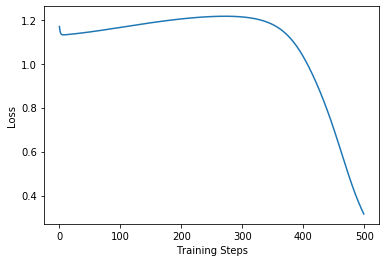

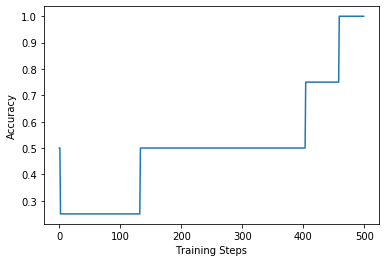

In [9]:
# Visualize the training progress. Loss and accuracy.
# If the performance does not reach 100% just rerun the cell above.
### YOUR CODE HERE ###
plt.figure()
plt.plot(epochs,losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs,accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.show()
######################